# Model from Su et al., 2017

<img src="Su.png" alt="drawing" width="200"/>

In [19]:
import cxcircuits.cx as cxlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Get the FBL client automatically created for
# the NeuroNLP window and attach the NeuroGFX window
# to the FBL client.

client = fbl.get_client()
for i in fbl.widget_manager.widgets:
    if fbl.widget_manager.widgets[i].widget_id not in fbl.client_manager.clients[fbl.widget_manager.widgets[i].client_id]['widgets']:
        fbl.client_manager.clients[fbl.widget_manager.widgets[i].client_id]['widgets'].append(fbl.widget_manager.widgets[i].widget_id)


In [24]:
# Initialize the constructor with the Su model.
cx = cxlib.CX_Constructor(client, 'Su_natcomms17')

[FBL Client NLP 2020-12-15 04:50:40] Received a message.
[FBL Client NLP 2020-12-15 04:50:41] Received a message.
[FBL Client NLP 2020-12-15 04:50:41] Received a message.
[FBL Client NLP 2020-12-15 04:50:41] Received a message.


populate the circuit diagram with parameters of the components

In [25]:
cx.initialize_diagram_config()

sending circuit configuration to GFX


Connectivity matrix between the neurons

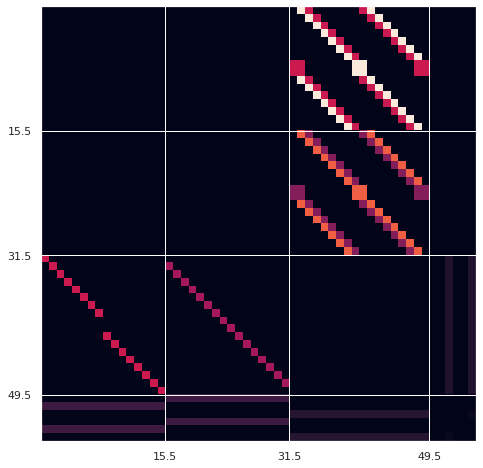

In [28]:
all_synapses = {n[1]['name']: n[0] for n in cx.data.nodes(data=True) if  n[1]['class'] in ['SynapseAMPA', 'SynapseGABA', 'SynapseNMDA']}
all_neurons = [n[1]['name'] for n in cx.data.nodes(data=True) if n[1]['class'] == 'LeakyIAFwithRefractoryPeriod']

a=sorted(cx.neurons_of_family('BU-EB').items())
b=a
neurons = sum(list([cx.neuron_uid_by_family('PB-EB-NO', 'PB/L{}'.format(10-i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('PB-EB-NO', 'PB/R{}'.format(i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('PB-EB-LAL', 'PB/L{}'.format(10-i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('PB-EB-LAL', 'PB/R{}'.format(i), 's') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('EB-LAL-PB', 'PB/L{}'.format(10-i), 'b') for i in range(1,10)]),[]) + \
          sum(list([cx.neuron_uid_by_family('EB-LAL-PB', 'PB/R{}'.format(i), 'b') for i in range(1,10)]),[]) + \
          [n[1] for n in b]

neuron_names = {cx.data.nodes[n]['name']: i for i, n in enumerate(neurons)}

connectivity = np.zeros((len(neuron_names), len(neuron_names)))
for synapse, rid in all_synapses.items():
    pre, post = synapse.split('_in_')[0].split('->')
    connectivity[neuron_names[pre], neuron_names[post]] += cx.data.nodes[rid]['gmax']

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
plt.imshow(connectivity)
ax.set_xticks([15.5, 31.5, 49.5], minor = False)
ax.set_yticks([15.5, 31.5, 49.5], minor = False)
ax.xaxis.grid(True, which = 'major')
ax.yaxis.grid(True, which = 'major')

In [29]:
# Disable the neuron family PB-EB-NO
cx.disable_neuron_family('PB-EB-NO')

sending circuit configuration to GFX


In [31]:
# execute the removal on in database
res = cx.remove_components()

[FBL Client NLP 2020-12-15 04:51:55] Received a message.
[FBL Client NLP 2020-12-15 04:51:56] Received a message.


Specify inputs, what to result to record

In [32]:
import itertools
shape = (200, 360)
dt = 1e-4
dur = 35.0
steps = int(dur/dt)
video_type = 'moving_bar_test'
bar_width = 20
EB_video_config = {'type': video_type,
                   'bar_width': bar_width,
                   'stop': dur,
                   'record': None}
EB_rf_config = {'sigma': 0.05}
PB_video_config = {'type': video_type,
                   'bar_width': bar_width,
                   'start': 1.0,
                   'stop': 35.,
                   'record': None,
                   'record_interval': 1000 #record every 100 steps of input video
                  }
PB_rf_config = {'num_glomeruli': 18}

PB_subregions = ['PB/L{}'.format(i) for i in range(1,10)] + \
                ['PB/R{}'.format(i) for i in range(1,10)]
PB_rids = list(itertools.chain.from_iterable([cx.neuron_uid_by_family('PB-EB-LAL', k) for k in PB_subregions]))
PB_neurons = {rid: cx.data.nodes[rid] for rid in PB_rids}

EB_rid = cx.rid_dict['Neuropil']['EB']
EB_models = [cx.find_models(neuron)[0] for neuron in cx.owns(EB_rid, 'Neuron')]
EB_neurons = {rid: cx.data.nodes[rid] for rid in EB_models if cx.data.nodes[rid]['name'] in ['EB/[1-8]/bs-BU/R3/s', 'EB/[1-8]/bs-bu/L3/s']}

# Since the PB-EB-LAL neuron is a PB neuron, it will be executed in the PB LPU.
# So we first create an entry for PB in the input_processors dict,
# with name "PB_InputProcessor" (See cx_fbl.cx_input).
# All the parameters should be spelt out in the dict.
# Additional input processors can be specified by extending the list.
# We do the same for 'BU' and 'bu' with "BU_InputProcessor".
input_processors = {'PB': [{'class': 'PB_Su_Bilateral_InputProcessor',
                            'name': 'PB',
                            'module': 'cxcircuits.cx_input', # this is where PB_InputProcessor should be imported from
                            'shape': shape,
                            'dt': dt,
                            'dur': dur,
                            'video_config': PB_video_config,
                            'rf_config': PB_rf_config,
                            'neurons': PB_neurons,
                            'scale': 1,
                            'record_file': 'PB_input.h5',
                            'record_interval': 100}],
                    'EB': [{'class': 'EB_Su_rEPG_InputProcessor', 
                            'name': 'EB',
                            'module': 'cxcircuits.cx_input', # this is where BU_InputProcessor should be imported from
                            'shape': shape,
                            'dt': dt,
                            'dur': dur,
                            'scale': 1.0,
                            'video_config': EB_video_config,
                            'rf_config': EB_rf_config,
                            'neurons': EB_neurons,
                            'record_file': 'EB_input.h5',
                            'record_interval': 10000}]
                   }

# Specify an output processor that is to record all nodes with an output of 'V' or 'spike_state'.
# The sample interval for voltage is every 10 steps. Spikes will be returned with spike time.
output_processors = {'PB': [{'class': 'Record',
                             'uid_dict': {#'V': {'uids': None},
                                          'spike_state': {'uids': None},
                                          #'g': {'uids': None}
                                         },
                             'sample_interval': 10}
                           ],
                     'EB': [{'class': 'Record',
                             'uid_dict': {#'V': {'uids': None},
                                          'spike_state': {'uids': None},
                                          #'g': {'uids': None}
                                         },
                             'sample_interval': 10}
                           ]
                    }


Execute the circuit

In [33]:
cx.execute(input_processors = input_processors,
           output_processors = output_processors,
           steps = steps, dt = dt)

[FBL Client NLP 2020-12-15 04:52:01] Received a message.
{'nlp': {'8774009101462448': {'name': 'flycircuit', 'dataset': 'flycircuit'}}, 'na': {'1469387748885118': {'name': 'flycircuit', 'dataset': 'flycircuit'}}, 'nk': {'2814058744828633': {'name': 'nk', 'version': 1.05}}}
[FBL Client NLP 2020-12-15 04:52:02] Received a message.
Execution request sent. Please wait.
[FBL Client NLP 2020-12-15 05:05:01] Receiving Execution Result for cx.  Please wait .....
[FBL Client NLP 2020-12-15 05:05:01] Received Execution Result for cx. Result stored in Client.exec_result['cx']


Get the simulation result, need to wait until execution result is received.

In [34]:
result = cx.get_result()

Plot EB response

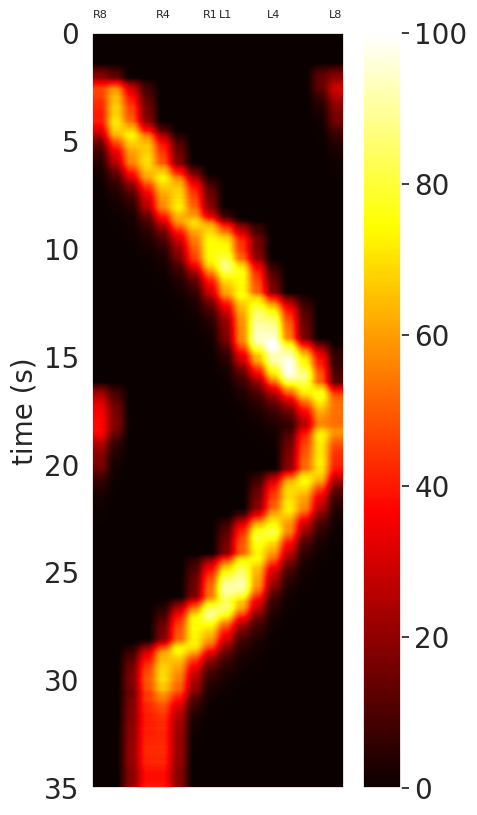

In [35]:
wedge_spike_rate = cx.show_EB_response(dur, dt, vmax = 100)

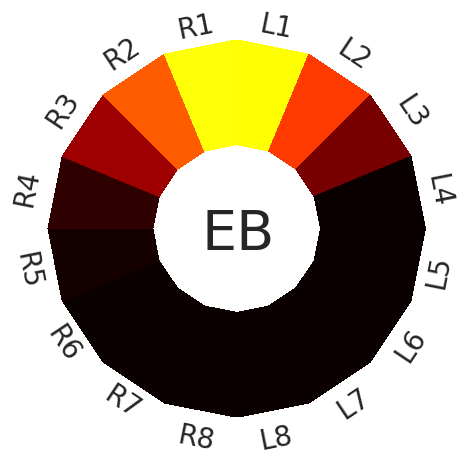

In [37]:
cx.show_EB_response_at_step(wedge_spike_rate, 100000, vmax = 100)